In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy

# Edge Detection

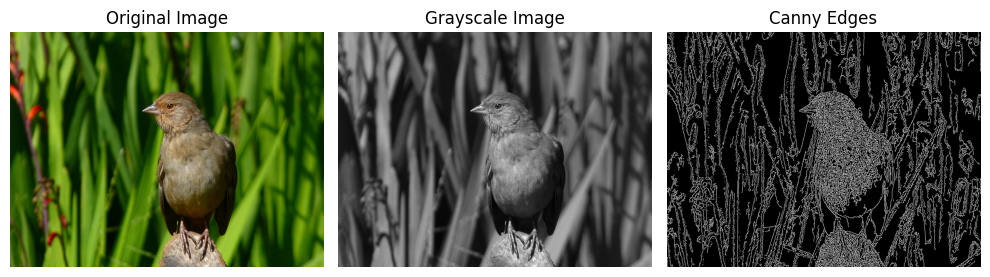

In [6]:

# Load image
img = cv2.imread('stock.jpeg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Visualize original image
plt.figure(figsize=(10, 12))
plt.subplot(3, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Convert to grayscale
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.subplot(3, 3, 2)
plt.imshow(img, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

# Detect edges
edges = cv2.Canny(img, 10, 50)
plt.subplot(3, 3, 3)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

plt.tight_layout()
plt.show()

## **Above Code Performs these tasks**  
* Taking the image as a input using cv2.imread function
* Converting the image from default BGR format of OpenCV to RGB color for further processing of this image
* Extracting the edge pixels of this image using Canny Edge detector function using cv2.Canny function

# Gradient through gausian gradient filter

In [ ]:
def g1x(x, y, s1):
    s1sq = s1 ** 2
    # Below expression computes the gradient filter in the x-direction
    # The factor -x/(2π*s1^4) corresponds to the derivative of the Gaussian function with respect to x.
    # The exponential term exp(-(x^2+y^2)/(2*s1^2)) models the Gaussian distribution.
    g = -1 * np.multiply(np.divide(x, 2 * np.pi * s1sq ** 2),np.exp(-1 * np.divide(x ** 2 + y ** 2, 2 * s1sq)))
    return g

def g1y(x, y, s1):

    # Same as g1x
    s1sq = s1 ** 2
    g = -1 * np.multiply(np.divide(y, 2 * np.pi * s1sq ** 2),np.exp(-1 * np.divide(x ** 2 + y ** 2, 2 * s1sq)))
    return g

def estimate_sparse_blur(gimg, edge_map, std1, std2):
    half_window = 11
    m = half_window * 2 + 1
    a = np.arange(-half_window, half_window + 1)
    xmesh = np.tile(a, (m, 1))
    ymesh = xmesh.T

    f11 = g1x(xmesh, ymesh, std1) # It represents the gradient gaussian filter in x-direction with std as std1
    f12 = g1y(xmesh, ymesh, std1) # It repreents the gradient gaussian filter in y-direction with std as std1

    f21 = g1x(xmesh, ymesh, std2) # It represents the gradient gaussian filter in x-direction with std as std2
    f22 = g1y(xmesh, ymesh, std2) # It repreents the gradient gaussian filter in y-direction with std as std2

    #This Convolves the image with obtained gradient filter std1 in x-direction and its also using nearest neighbourhood padding
    gimx1 = scipy.ndimage.convolve(gimg, f11, mode='nearest')
    gimy1 = scipy.ndimage.convolve(gimg, f12, mode='nearest')
    mg1 = np.sqrt(gimx1 ** 2 + gimy1 ** 2)
    
    #This Convolves the image with obtained gradient filter std2 in x-direction and its also using nearest neighbourhood padding
    gimx2 = scipy.ndimage.convolve(gimg, f21, mode='nearest')
    gimy2 = scipy.ndimage.convolve(gimg, f22, mode='nearest')
    mg2 = np.sqrt(gimx2 ** 2 + gimy2 ** 2)

    # Taking the ratio of gradients and adding a small value to avoid division by zero
    R = np.divide(mg1, mg2 + 1e-20) 
    R = np.multiply(R, edge_map > 0)  # Only consider edge locations

    # Estimate sparse blur values
    sparse_vals = np.divide(R ** 2 * (std1 ** 2) - (std2 ** 2), 1 - R ** 2 + 1e-10)
    sparse_vals[sparse_vals < 0] = 0

    sparse_bmap = np.sqrt(sparse_vals)
    sparse_bmap[np.isnan(sparse_bmap)] = 0
    sparse_bmap[sparse_bmap > 5] = 5  # Cap maximum value at 5

    return sparse_bmap,mg1,mg2

sparse_bmap,mag1,mag2 = estimate_sparse_blur(img, edges, std1=1, std2=2)

plt.figure(figsize=(10, 12))

plt.subplot(2, 2, 1)
plt.imshow(mag1, cmap='hot')
plt.title('Gradient Orig (Edges Only)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(mag2, cmap='hot')
plt.title('Gradient Smooth (Edges Only)')
plt.axis('off')

plt.tight_layout()
plt.show()

C:\Users\barat\AppData\Local\Temp\ipykernel_5764\2944653288.py:40: RuntimeWarning: divide by zero encountered in divide
  R = np.divide(mg1, mg2 + 1e-20)
C:\Users\barat\AppData\Local\Temp\ipykernel_5764\2944653288.py:40: RuntimeWarning: invalid value encountered in divide
  R = np.divide(mg1, mg2 + 1e-20)
C:\Users\barat\AppData\Local\Temp\ipykernel_5764\2944653288.py:41: RuntimeWarning: invalid value encountered in multiply
  R = np.multiply(R, edge_map > 0)  # Only consider edge locations
C:\Users\barat\AppData\Local\Temp\ipykernel_5764\2944653288.py:44: RuntimeWarning: divide by zero encountered in divide
  sparse_vals = np.divide(R ** 2 * (std1 ** 2) - (std2 ** 2), 1 - R ** 2 + 1e-10)
C:\Users\barat\AppData\Local\Temp\ipykernel_5764\2944653288.py:44: RuntimeWarning: invalid value encountered in divide
  sparse_vals = np.divide(R ** 2 * (std1 ** 2) - (std2 ** 2), 1 - R ** 2 + 1e-10)


TypeError: 'numpy.ndarray' object is not callable

## **Above Code Performs these tasks** 
*  First Image obtained was processed with gaussian gradient filter with std as 1
* Second image obtained was was processed with gaussian gradient filter with std as 2
*  We can observe here that first image is more brighter than the second image as expected due to high std of filter used in second

# Sparse Defocus Map

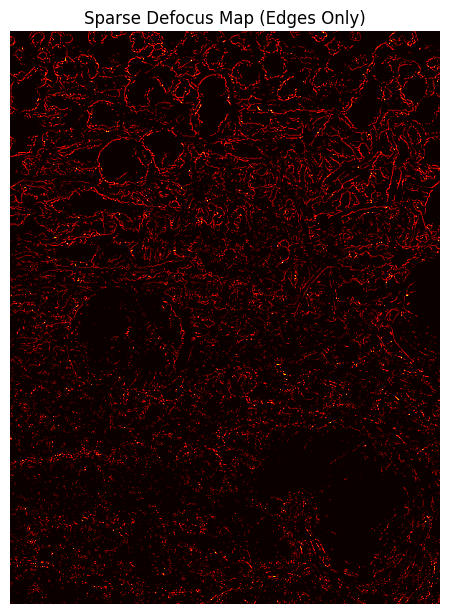

In [ ]:
plt.figure(figsize=(15, 18))
plt.subplot(3,3,2)
plt.imshow(sparse_bmap, cmap='hot')
plt.title('Sparse Defocus Map (Edges Only)')
plt.axis('off')
plt.tight_layout()
plt.show()

#### We see that average intensity of the Sparse Defocus map intensity increases as we move up from bottom to top which indicates that defocus increases from bottom to top aand is in accordance with original image 

# Example 2 for Sparse Map

/tmp/ipykernel_30/2054181310.py:40: RuntimeWarning: divide by zero encountered in divide
  R = np.divide(mg1, mg2 + 1e-20)
/tmp/ipykernel_30/2054181310.py:40: RuntimeWarning: invalid value encountered in divide
  R = np.divide(mg1, mg2 + 1e-20)
/tmp/ipykernel_30/2054181310.py:41: RuntimeWarning: invalid value encountered in multiply
  R = np.multiply(R, edge_map > 0)  # Only consider edge locations
/tmp/ipykernel_30/2054181310.py:44: RuntimeWarning: divide by zero encountered in divide
  sparse_vals = np.divide(R ** 2 * (std1 ** 2) - (std2 ** 2), 1 - R ** 2 + 1e-10)
/tmp/ipykernel_30/2054181310.py:44: RuntimeWarning: invalid value encountered in divide
  sparse_vals = np.divide(R ** 2 * (std1 ** 2) - (std2 ** 2), 1 - R ** 2 + 1e-10)


600


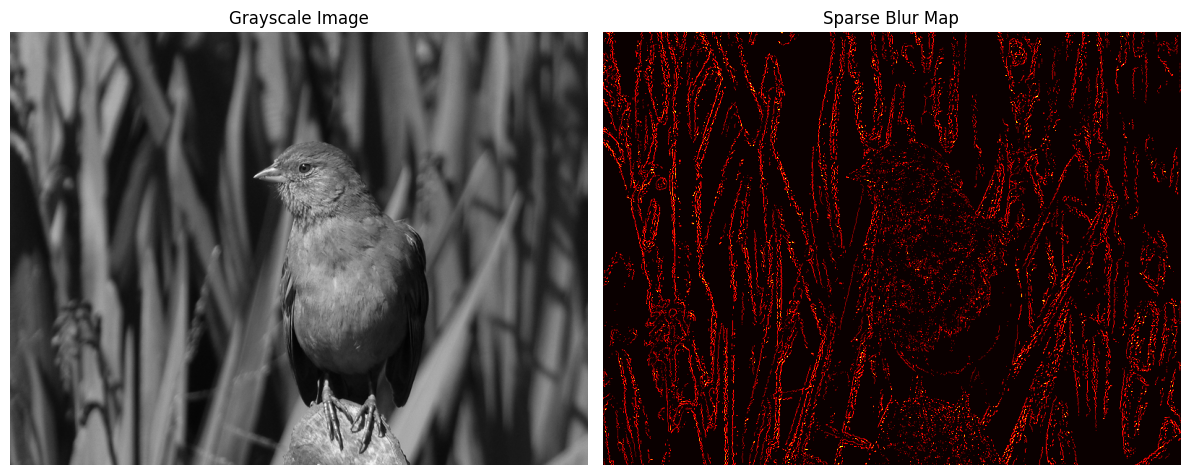

In [ ]:
import numpy as np
import scipy.ndimage
import cv2
import matplotlib.pyplot as plt


# Example usage
# Load a grayscale image and create an edge map
gimg = cv2.imread('/kaggle/input/fdme-images/pr11_bird.png', cv2.IMREAD_COLOR)
gimg = cv2.cvtColor(gimg, cv2.COLOR_BGR2RGB)
gimg = cv2.cvtColor(gimg, cv2.COLOR_RGB2GRAY)

edge_map = cv2.Canny(gimg, 10, 50)  # Generate edge map using Canny

# Define standard deviations
std1 = 1
std2 = 2

# Estimate sparse blur
sparse_bmap,mg1,mg2 = estimate_sparse_blur(gimg, edge_map, std1, std2)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(gimg, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sparse_bmap, cmap='hot')
plt.title('Sparse Blur Map')
plt.axis('off')

print(len(sparse_bmap))

plt.tight_layout()
plt.show()

# Super Pixelation using SLIC

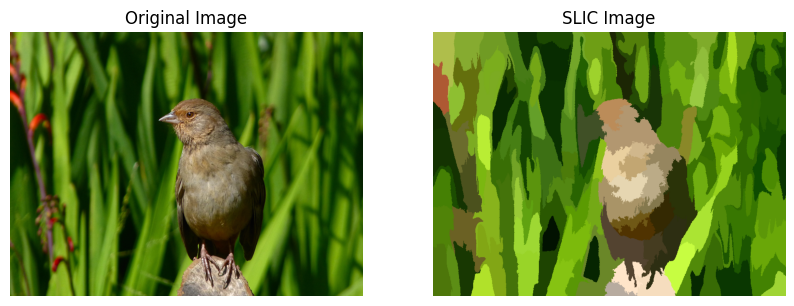

In [ ]:

    
import numpy as np
import cv2
from skimage.segmentation import slic
from skimage.color import rgb2ycbcr
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('/kaggle/input/fdme-images/pr11_bird.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Parameters
N = 200  # Number of superpixels
compactness = 10  # Compactness for SLIC


# Step 2: Apply SLIC to segment the image into superpixels
superpixels = slic(image_rgb, n_segments=N, compactness=compactness, start_label=1)



# Step 3: Compute the mean color for each superpixel in the YCrCb color space
superpixel_features = {}
for i in range(1, np.max(superpixels) + 1):
    mask = superpixels == i
    superpixel_features[i] = np.mean(image_rgb[mask], axis=0)  # Compute mean for superpixel

# Step 4: Assign the mean color back to each superpixel
superpixel_colored = np.zeros_like(image_rgb)
for i in range(1, np.max(superpixels) + 1):
    mask = superpixels == i
    superpixel_colored[mask] = superpixel_features[i]  # Assign mean color to superpixel

# Convert the superpixel_colored image back to RGB for visualization
superpixel_colored_rgb = (superpixel_colored / np.max(superpixel_colored) * 255).astype(np.uint8)

# Step 5: Visualize the original and superpixel-colored image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superpixel_colored_rgb)
plt.title('SLIC Image')
plt.axis('off')

plt.show()


####  The above part of code performs the task of dividing the image into a set of superpixels using SLIC agorithm.This divison of superpixels is necessary to propage the obtained sparse defocus map to each of these supexpixels instead of doing it through the time consuming pixel level propagation

# Super Pixelation Using SNIC

(-0.5, 799.5, 599.5, -0.5)

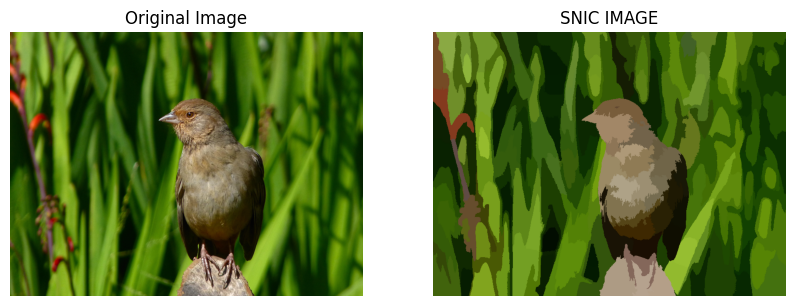

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import heapq
from skimage import color

# we define the data structure for priority queue to store the pixels.
class Node:
    def __init__(self, index, label, dist):
        self.index = index
        self.label = label
        self.dist = dist
    
    def __lt__(self, other):
        return self.dist < other.dist

def push(heap, index, label, dist):
    node = Node(index, label, dist)
    heapq.heappush(heap, node)

def pop(heap):
    return heapq.heappop(heap)

def rgb_to_lab(img):
    return color.rgb2lab(img)

# For initializing seed we place them in a gris with roughly uniform spacing
def find_seeds(width, height, numk):
    size = width * height
    gridstep = int(np.sqrt(size / numk) + 0.5) 
    halfstep = gridstep // 2
    seeds = []
    for y in range(halfstep, height, gridstep):  
        for x in range(halfstep, width, gridstep):  
            seeds.append((x, y))  

    return seeds

def run_snic(image, numk, compactness):
    height, width, channels = image.shape
    sz = width * height
    lab_image = rgb_to_lab(image)
    
    # Initialize labels and other tracking variables
    labels = np.full((height, width), 0, dtype=int)  
    heap = []
    kx, ky, ksize = np.zeros(numk), np.zeros(numk), np.zeros(numk)
    kc = [np.zeros(numk) for _ in range(3)]  

    
    #We generate the seeds 
    seeds = find_seeds(width, height, numk)
    
    # We initialize the priority queue
    for k, (x, y) in enumerate(seeds):
        index = y * width + x  # Flattened pixel index
        push(heap, index, k, 0)  # Push the seed to the heap
    
    # Set compactness our hyperparameter
    M = compactness
    invwt = (M * M * numk) / sz  
    
    dx8 = [-1, 0, 1, 0, -1, 1, 1, -1]
    dy8 = [0, -1, 0, 1, -1, -1, 1, 1]
    
    pixel_count = 0  
    
    # We process each pixel based on distance and similarity
    while pixel_count < sz:
        node = pop(heap)
        ind, k, dist = node.index, node.label, node.dist
        x, y = ind % width, ind // width
        i = y * width + x
        
        if labels[y, x] == 0:  # If pixel hasn't been labeled yet
            labels[y, x] = k + 1  # Assign the superpixel label
            pixel_count += 1
            
            # Update the superpixel center (mean color and position)
            for c in range(3): 
                kc[c][k] += lab_image[y, x, c]
            kx[k] += x
            ky[k] += y
            ksize[k] += 1
            
            # We examine neighbors for 4-connectivity
            for p in range(4):  
                xx, yy = x + dx8[p], y + dy8[p]
                if 0 <= xx < width and 0 <= yy < height:  # Ensure within bounds
                    ii = yy * width + xx  # Flattened pixel index
                    if labels[yy, xx] == 0:  # If neighbor is unprocessed
                        # We compute color distance and spatial distance
                        colordist = sum([(kc[c][k] - lab_image[yy, xx, c] * ksize[k]) ** 2 for c in range(3)])
                        xdiff = kx[k] - xx * ksize[k]
                        ydiff = ky[k] - yy * ksize[k]
                        xydist = xdiff * xdiff + ydiff * ydiff
                        
                        # we combine color and spatial distance (compactness factor used)
                        slicdist = (colordist + xydist * invwt) / (ksize[k] ** 2)
                        
                        # we push the neighboring pixel into the heap for processing
                        push(heap, ii, k, slicdist)
    
    return labels

image = cv2.imread('/kaggle/input/fdme-images/pr11_bird.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


numk = 200  
compactness = 10 
labels = run_snic(image, numk, compactness)

output_image = np.zeros_like(image)
for label in np.unique(labels):
    mask = labels == label
    mean_color = image[mask].mean(axis=0)
    output_image[mask] = mean_color
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('SNIC IMAGE')
plt.axis('off')

#####  In the above code we implement SNIC(Simple NON iterative Clustering ) which uses a priority queue instead of the K means clustering used in SLIC. SNIC has better boundary adherence and is even faster than SLIC

# Adjacency Weight Matrix SLIC

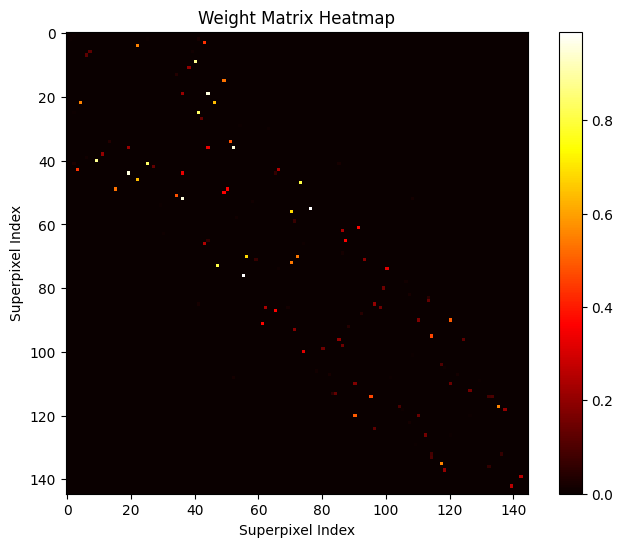

In [ ]:
import numpy as np
import cv2
from scipy import sparse
from collections import defaultdict
from skimage.segmentation import mark_boundaries

image_ycrcb = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)


# Find adjacent superpixels by looking at each label of pixel to adjacent pixels 
def find_adjacent_superpixels(labels):
    adjacency = defaultdict(set)
    for i in range(labels.shape[0] - 1):
        for j in range(labels.shape[1] - 1):
            current_sp = labels[i, j]
            neighbors = [labels[i + 1, j], labels[i, j + 1], labels[i + 1, j + 1], labels[i + 1, j - 1]]
            for neighbor in neighbors:
                if neighbor != current_sp:
                    adjacency[current_sp].add(neighbor)
                    adjacency[neighbor].add(current_sp)
    return adjacency

# Calculate mean color for each superpixel
superpixel_features = {}
for i in range(1, np.max(superpixels) + 1):
    mask = superpixels == i
    superpixel_features[i] = np.mean(image_ycrcb[mask], axis=0)

# Get adjacency relationships
adjacency = find_adjacent_superpixels(superpixels)

# Initialize and compute weight matrix based on adjacency
num_superpixels = np.max(superpixels)
weight_matrix = np.zeros((num_superpixels + 1, num_superpixels + 1))

for i in range(1, num_superpixels + 1):
    for j in adjacency[i]:
        # Compute Gaussian weight based on YCbCr feature similarity and by taking std as 4
        feature_i = superpixel_features[i]
        feature_j = superpixel_features[j]
        distance = np.linalg.norm(feature_i - feature_j)
        weight = np.exp(-distance ** 2 / (2 * 4 ** 2))
        weight_matrix[i, j] = weight

plt.figure(figsize=(8, 6))
plt.imshow(weight_matrix[1:, 1:], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Weight Matrix Heatmap')
plt.xlabel('Superpixel Index')
plt.ylabel('Superpixel Index')
plt.show()

##### The above part of code obtains the grah where each node represents the superpixels and weights are assigned to this graph taking difference between mean YCrCb color for each of these superpixels and applying the gaussian function to this distance with std as 4.We can observe that adjacent superpixels which are more related are assigned weight of equal to 1 and superpixels that are not connected are assigned to a weight of zero

# Depth Propogation after SLIC

/tmp/ipykernel_30/2054181310.py:40: RuntimeWarning: divide by zero encountered in divide
  R = np.divide(mg1, mg2 + 1e-20)
/tmp/ipykernel_30/2054181310.py:40: RuntimeWarning: invalid value encountered in divide
  R = np.divide(mg1, mg2 + 1e-20)
/tmp/ipykernel_30/2054181310.py:41: RuntimeWarning: invalid value encountered in multiply
  R = np.multiply(R, edge_map > 0)  # Only consider edge locations
/tmp/ipykernel_30/2054181310.py:44: RuntimeWarning: divide by zero encountered in divide
  sparse_vals = np.divide(R ** 2 * (std1 ** 2) - (std2 ** 2), 1 - R ** 2 + 1e-10)
/tmp/ipykernel_30/2054181310.py:44: RuntimeWarning: invalid value encountered in divide
  sparse_vals = np.divide(R ** 2 * (std1 ** 2) - (std2 ** 2), 1 - R ** 2 + 1e-10)


[[  1   1   1 ...  20  20  20]
 [  1   1   1 ...  20  20  20]
 [  1   1   1 ...  20  20  20]
 ...
 [181 181 181 ... 185 185 185]
 [181 181 181 ... 185 185 185]
 [181 181 181 ... 185 185 185]]


/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


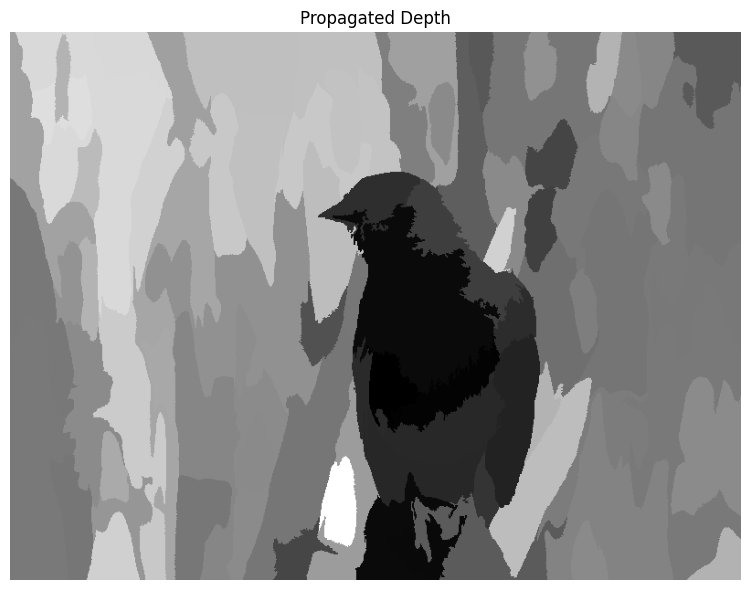

In [ ]:


def superpixel_depth_propagation(image_rgb, n_segments=200, compactness=20, alpha=0.0001, sigma=4):
    superpixels = slic(image_rgb, n_segments=n_segments, compactness=compactness, start_label=1)
    print(superpixels)
    image_ycrcb = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)
    
# Find adjacent superpixels by looking at each label of pixel to adjacent pixels 
    def find_adjacent_superpixels(labels):
        adjacency = defaultdict(set)
        for i in range(labels.shape[0] - 1):
            for j in range(labels.shape[1] - 1):
                current_sp = labels[i, j]
                neighbors = [labels[i + 1, j], labels[i, j + 1], 
                           labels[i + 1, j + 1], labels[i + 1, j - 1]]
                for neighbor in neighbors:
                    if neighbor != current_sp:
                        adjacency[current_sp].add(neighbor)
                        adjacency[neighbor].add(current_sp)
        return adjacency
    
    # Calculate mean color for each superpixel
    superpixel_features = {}
    for i in range(1, np.max(superpixels) + 1):
        mask = superpixels == i
        superpixel_features[i] = np.mean(image_ycrcb[mask], axis=0)
    
    # Get adjacency relationships
    adjacency = find_adjacent_superpixels(superpixels)
    
    # Initialize and compute weight matrix based on adjacency
    num_superpixels = np.max(superpixels)
    
    # Create sparse matrix entries
    rows = []
    cols = []
    weights = []
    
    for i in range(1, num_superpixels + 1):
        for j in adjacency[i]:
            # Compute Gaussian weight based on YCbCr feature similarity by taking mean YCbCr distance of each of these superpixels
            feature_i = superpixel_features[i]
            feature_j = superpixel_features[j]
            distance = np.linalg.norm(feature_i - feature_j)
            
            weight = np.exp(-distance ** 2 / (2 * sigma ** 2)) + 1e-36
            
            # Add symmetric entries
            rows.extend([i-1, j-1])  # -1 because sparse matrix is 0-based
            cols.extend([j-1, i-1])
            weights.extend([weight, weight])
    
    # Create sparse weight matrix that defines the Local relationship between each of these superpixels considering only the pixels that are adjacent
    W = sparse.csr_matrix((weights, (rows, cols)), 
                         shape=(num_superpixels, num_superpixels))
    
    # Compute degree matrix that deines the global relationship between each of these superpixels and needs to be used to calculate Transductive Affinity Matrix
    D = sparse.diags(W.sum(axis=1).A1)
    
    # Compute Transductive Affinity Matrix that defines similarity between each of these superpixels by using D and W 
    I = sparse.eye(num_superpixels)
    A = alpha * sparse.linalg.inv(D - (1-alpha)*W) @ I #Parameter alpha here denotes the priority given to D(global relationship) to W(Local Relationship)

    # The below part of code assign defocus values to each of the superpixels by taking mean values across the pixels in its egde by taking assigning it to median value of it 
    def propagate_depth(sparse_depth_map, seed_mask):
        # Initialize superpixel depth values
        val_sp = np.zeros(num_superpixels)
        for i in range(1, num_superpixels + 1):
            mask = (superpixels == i) & seed_mask
            if np.sum(mask) >= 2:  # Minimum number of seed points
                val_sp[i-1] = np.median(sparse_depth_map[mask])
            else:
                val_sp[i-1] = -1
        
        # Set invalid depth columns to zero
        A_modified = A.copy()
        A_modified[:, val_sp == -1] = 0
        
        # Normalize rows to sum to 1
        
        row_sums = A_modified.sum(axis=1).A1

        # Avoid division by zero
        row_sums[row_sums == 0] = 1  
        A_hat = sparse.diags(1/row_sums) @ A_modified
        
# Propagate depth values using the Transductive Affinity matrix obtained above so through this we can take into consideration of how each of superpixels values are affected by adjacent superpixels
        new_val_sp = A_hat @ val_sp
        
        # Create final depth map
        depth_map = np.zeros_like(sparse_depth_map)
        for i in range(1, num_superpixels + 1):
            depth_map[superpixels == i] = new_val_sp[i-1]
        
        # Normalize to 0-1
        depth_map = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))
        return depth_map
    
    return propagate_depth, superpixels


def process_image(image_rgb, sparse_depth, seed_mask, n_segments, compactness):
    
    propagate_depth, superpixels = superpixel_depth_propagation(
        image_rgb, n_segments=n_segments, compactness=compactness
    )
    dense_depth = propagate_depth(sparse_depth, seed_mask)
    
    return dense_depth, superpixels
    
image = cv2.imread('/kaggle/input/fdme-images/pr11_bird.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gimg = cv2.imread('/kaggle/input/fdme-images/pr11_bird.png', cv2.IMREAD_GRAYSCALE)

edge_map = cv2.Canny(gimg, 10, 50)
sparse_depth,e1,e2 = estimate_sparse_blur(gimg, edge_map, 1, 2)
seed_mask = sparse_depth > 0


dense_depth, superpixels = process_image(
    image_rgb, 
    sparse_depth, 
    seed_mask,
    n_segments=200,
    compactness=20,
)

plt.figure(figsize=(15, 6))

plt.imshow(dense_depth, cmap='gray')
plt.title('Propagated Depth')
plt.axis('off')

plt.tight_layout()
plt.show()


##### The Above image is the defocus map estimation of the original image we can observe through this image Bird is having the darker pixels which indicates it is foreground of image and its less defocussed and the part of image side of bird is lightened indicating this part is defocused and this is in accordance with original image

# Adjacenecy Matrix after SNIC

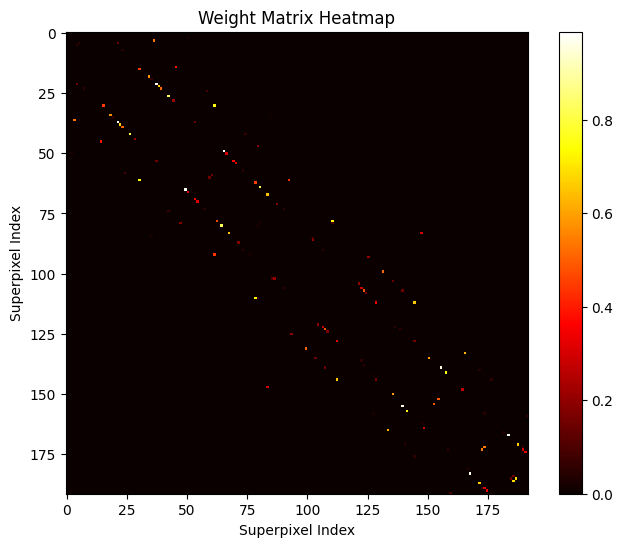

In [ ]:
import numpy as np
import cv2
from scipy import sparse
from collections import defaultdict
from skimage.segmentation import mark_boundaries

image_ycrcb = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)


# Find adjacent superpixels by looking at each label of pixel to adjacent pixels 
def find_adjacent_superpixels(labels):
    adjacency = defaultdict(set)
    for i in range(labels.shape[0] - 1):
        for j in range(labels.shape[1] - 1):
            current_sp = labels[i, j]
            neighbors = [labels[i + 1, j], labels[i, j + 1], labels[i + 1, j + 1], labels[i + 1, j - 1]]
            for neighbor in neighbors:
                if neighbor != current_sp:
                    adjacency[current_sp].add(neighbor)
                    adjacency[neighbor].add(current_sp)
    return adjacency

# Calculate mean color for each superpixel
superpixel_features = {}
for i in range(1, np.max(labels) + 1):
    mask = labels == i
    superpixel_features[i] = np.mean(image_ycrcb[mask], axis=0)

# Get adjacency relationships
adjacency = find_adjacent_superpixels(labels)

# Initialize and compute weight matrix based on adjacency
num_superpixels = np.max(labels)
weight_matrix = np.zeros((num_superpixels + 1, num_superpixels + 1))

for i in range(1, num_superpixels + 1):
    for j in adjacency[i]:
        # Compute Gaussian weight based on YCbCr feature similarity and by taking std as 4
        feature_i = superpixel_features[i]
        feature_j = superpixel_features[j]
        distance = np.linalg.norm(feature_i - feature_j)
        weight = np.exp(-distance ** 2 / (2 * 4 ** 2))
        weight_matrix[i, j] = weight

plt.figure(figsize=(8, 6))
plt.imshow(weight_matrix[1:, 1:], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Weight Matrix Heatmap')
plt.xlabel('Superpixel Index')
plt.ylabel('Superpixel Index')
plt.show()

# Depth Propogation After SNIC

/tmp/ipykernel_30/2054181310.py:40: RuntimeWarning: divide by zero encountered in divide
  R = np.divide(mg1, mg2 + 1e-20)
/tmp/ipykernel_30/2054181310.py:40: RuntimeWarning: invalid value encountered in divide
  R = np.divide(mg1, mg2 + 1e-20)
/tmp/ipykernel_30/2054181310.py:41: RuntimeWarning: invalid value encountered in multiply
  R = np.multiply(R, edge_map > 0)  # Only consider edge locations
/tmp/ipykernel_30/2054181310.py:44: RuntimeWarning: divide by zero encountered in divide
  sparse_vals = np.divide(R ** 2 * (std1 ** 2) - (std2 ** 2), 1 - R ** 2 + 1e-10)
/tmp/ipykernel_30/2054181310.py:44: RuntimeWarning: invalid value encountered in divide
  sparse_vals = np.divide(R ** 2 * (std1 ** 2) - (std2 ** 2), 1 - R ** 2 + 1e-10)


[[ 33  33  33 ...  16  16  16]
 [ 33  33  33 ...  16  16  16]
 [ 33  33  33 ...  16  16  16]
 ...
 [177 177 177 ... 192 192 192]
 [177 177 177 ... 192 192 192]
 [177 177 177 ... 192 192 192]]


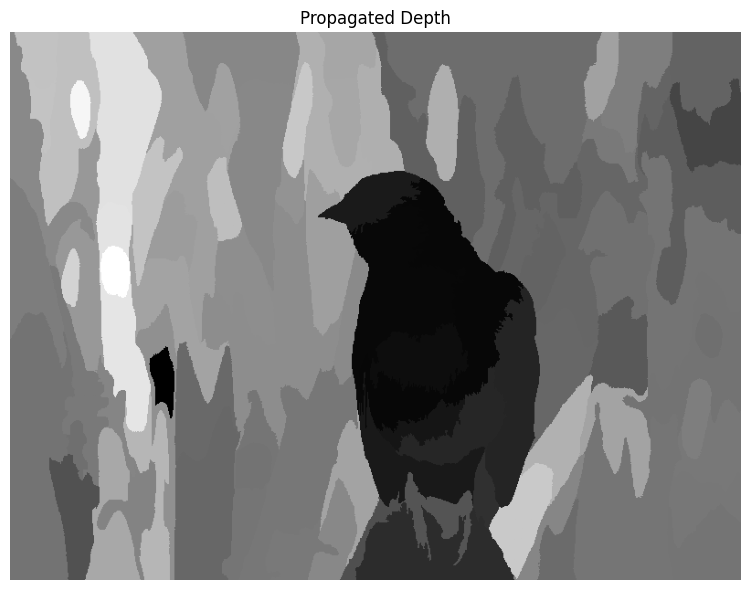

In [ ]:


def superpixel_depth_propagation(image_rgb, n_segments=200, compactness=20, alpha=0.0001, sigma=4):
    superpixels = run_snic(image_rgb,n_segments,compactness)
    print(superpixels)
    image_ycrcb = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)
    
# Find adjacent superpixels by looking at each label of pixel to adjacent pixels 
    def find_adjacent_superpixels(labels):
        adjacency = defaultdict(set)
        for i in range(labels.shape[0] - 1):
            for j in range(labels.shape[1] - 1):
                current_sp = labels[i, j]
                neighbors = [labels[i + 1, j], labels[i, j + 1], 
                           labels[i + 1, j + 1], labels[i + 1, j - 1]]
                for neighbor in neighbors:
                    if neighbor != current_sp:
                        adjacency[current_sp].add(neighbor)
                        adjacency[neighbor].add(current_sp)
        return adjacency
    
    # Calculate mean color for each superpixel
    superpixel_features = {}
    for i in range(1, np.max(superpixels) + 1):
        mask = superpixels == i
        superpixel_features[i] = np.mean(image_ycrcb[mask], axis=0)
    
    # Get adjacency relationships
    adjacency = find_adjacent_superpixels(superpixels)
    
    # Initialize and compute weight matrix based on adjacency
    num_superpixels = np.max(superpixels)
    
    # Create sparse matrix entries
    rows = []
    cols = []
    weights = []
    
    for i in range(1, num_superpixels + 1):
        for j in adjacency[i]:
            # Compute Gaussian weight based on YCbCr feature similarity by taking mean YCbCr distance of each of these superpixels
            feature_i = superpixel_features[i]
            feature_j = superpixel_features[j]
            distance = np.linalg.norm(feature_i - feature_j)
            
            weight = np.exp(-distance ** 2 / (2 * sigma ** 2)) + 1e-36
            
            # Add symmetric entries
            rows.extend([i-1, j-1])  # -1 because sparse matrix is 0-based
            cols.extend([j-1, i-1])
            weights.extend([weight, weight])
    
    # Create sparse weight matrix that defines the Local relationship between each of these superpixels considering only the pixels that are adjacent
    W = sparse.csr_matrix((weights, (rows, cols)), 
                         shape=(num_superpixels, num_superpixels))
    
    # Compute degree matrix that deines the global relationship between each of these superpixels and needs to be used to calculate Transductive Affinity Matrix
    D = sparse.diags(W.sum(axis=1).A1)
    
    # Compute Transductive Affinity Matrix that defines similarity between each of these superpixels by using D and W 
    I = sparse.eye(num_superpixels)
    A = alpha * sparse.linalg.inv(D - (1-alpha)*W) @ I #Parameter alpha here denotes the priority given to D(global relationship) to W(Local Relationship)

    # The below part of code assign defocus values to each of the superpixels by taking mean values across the pixels in its egde by taking assigning it to median value of it 
    def propagate_depth(sparse_depth_map, seed_mask):
        # Initialize superpixel depth values
        val_sp = np.zeros(num_superpixels)
        for i in range(1, num_superpixels + 1):
            mask = (superpixels == i) & seed_mask
            if np.sum(mask) >= 2:  # Minimum number of seed points
                val_sp[i-1] = np.median(sparse_depth_map[mask])
            else:
                val_sp[i-1] = -1
        
        # Set invalid depth columns to zero
        A_modified = A.copy()
        A_modified[:, val_sp == -1] = 0
        
        # Normalize rows to sum to 1
        
        row_sums = A_modified.sum(axis=1).A1

        # Avoid division by zero
        row_sums[row_sums == 0] = 1  
        A_hat = sparse.diags(1/row_sums) @ A_modified
        
# Propagate depth values using the Transductive Affinity matrix obtained above so through this we can take into consideration of how each of superpixels values are affected by adjacent superpixels
        new_val_sp = A_hat @ val_sp
        
        # Create final depth map
        depth_map = np.zeros_like(sparse_depth_map)
        for i in range(1, num_superpixels + 1):
            depth_map[superpixels == i] = new_val_sp[i-1]
        
        # Normalize to 0-1
        depth_map = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))
        return depth_map
    
    return propagate_depth, superpixels


def process_image(image_rgb, sparse_depth, seed_mask, n_segments, compactness):
    
    propagate_depth, superpixels = superpixel_depth_propagation(
        image_rgb, n_segments=n_segments, compactness=compactness
    )
    dense_depth = propagate_depth(sparse_depth, seed_mask)
    
    return dense_depth, superpixels
    
image = cv2.imread('/kaggle/input/fdme-images/pr11_bird.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gimg = cv2.imread('/kaggle/input/fdme-images/pr11_bird.png', cv2.IMREAD_GRAYSCALE)

edge_map = cv2.Canny(gimg, 10, 50)
sparse_depth,e1,e2 = estimate_sparse_blur(gimg, edge_map, 1, 2)
seed_mask = sparse_depth > 0


dense_depth, superpixels = process_image(
    image_rgb, 
    sparse_depth, 
    seed_mask,
    n_segments=200,
    compactness=20,
)

plt.figure(figsize=(15, 6))

plt.imshow(dense_depth, cmap='gray')
plt.title('Propagated Depth')
plt.axis('off')

plt.tight_layout()
plt.show()


0.6353
0.849
0.847
0.6255
0.7485
0.7485
0.7524
0.7524
0.4976
0.6274
0.6274
0.369
0.3464
0.4644
0.5693
0.463
0.7065
0.541
0.5254
0.3523
0.7065
0.7485
0.458
0.764
0.3523
0.7593
0.849
0.8677
0.6255
0.4644
0.542
0.458
0.7847
0.7827
0.5254
0.6353
0.818
0.4644
0.4585
0.369
0.6274
0.4976
0.7534
0.7837
0.849
0.7593
0.27
0.849
0.734
0.4707
0.458
0.739
0.651
0.7847
0.542
0.4707
0.849
0.7534
0.542
0.181
0.369
0.818
0.48
0.4722
0.2441
0.7827
0.636
0.2524
0.5674
0.4595
0.739
0.4712
0.651
0.457
0.85
0.03964
0.818
0.7534
0.03964
0.4338
0.7065
0.5674
0.5674
0.48
0.578
0.649
0.4722
0.459
0.03964
0.2441
0.4648
0.85
0.4722
0.739
0.651
0.4937
0.4722
0.5674
0.3215
0.4766
0.1722
0.03964
0.03964
0.459
0.7944
0.03964
0.5674
0.5537
0.4722
0.5234
0.48
0.474
0.4338
0.4727
0.546
0.4644
0.6597
0.03964
0.1365
0.01468
0.1644
0.4722
0.5674
0.459
0.0
0.7935
0.7065
0.544
0.4727
0.1581
0.5234
0.6094
0.546
0.01468
0.7407
0.474
0.651
0.4644
0.4863
0.5156
0.136
0.7935
0.156
0.164
0.542
0.4746
0.5234
0.546
0.4644
0.6655
0.4

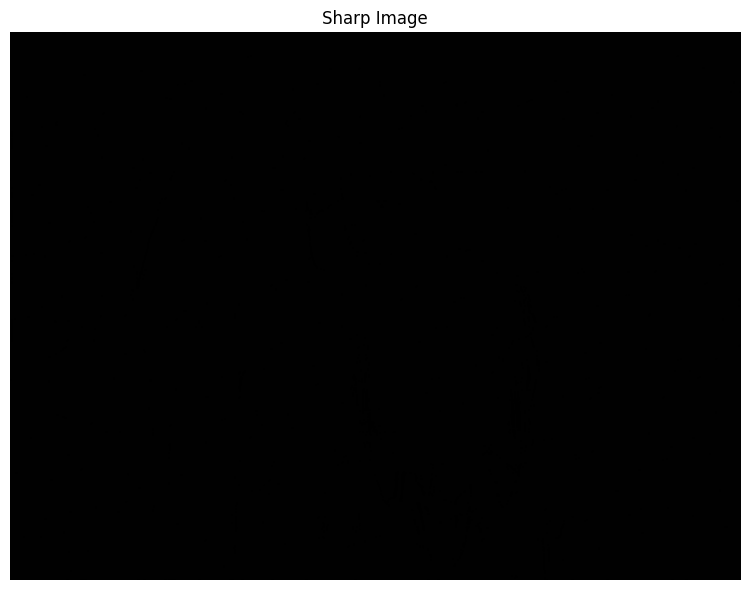

In [ ]:
def compute_psf(depth, depth_focus, max_blur=10000, kernel_size=5):
    blur_extent = max_blur * abs(depth - depth_focus)  
    psf = cv2.getGaussianKernel(kernel_size, blur_extent)
    psf = psf @ psf.T  # Create 2D PSF
    return psf
    
from skimage.restoration import richardson_lucy
def deblur_superpixels(image_blurred, superpixels, depth_map, depth_focus, num_iterations=30):
    sharp_image = np.zeros_like(image_blurred) 
    for sp_id in range(1, np.max(superpixels) + 1):
        mask = superpixels == sp_id
        region = image_blurred[mask]
        avg_depth = np.mean(depth_map[mask])
        print(avg_depth)
        psf = compute_psf(avg_depth, depth_focus)
        region_sharp = richardson_lucy(region, psf)
        sharp_image[mask] = region_sharp  
    return sharp_image

sharp_image = deblur_superpixels(
    image_blurred=image_rgb,
    superpixels=superpixels,
    depth_map=dense_depth,
    depth_focus=0.5,  
)

plt.figure(figsize=(15, 6))

plt.imshow(sharp_image)
plt.title('Sharp Image')
plt.axis('off')

plt.tight_layout()
plt.show()